In [11]:
import torch
import torch.nn as nn

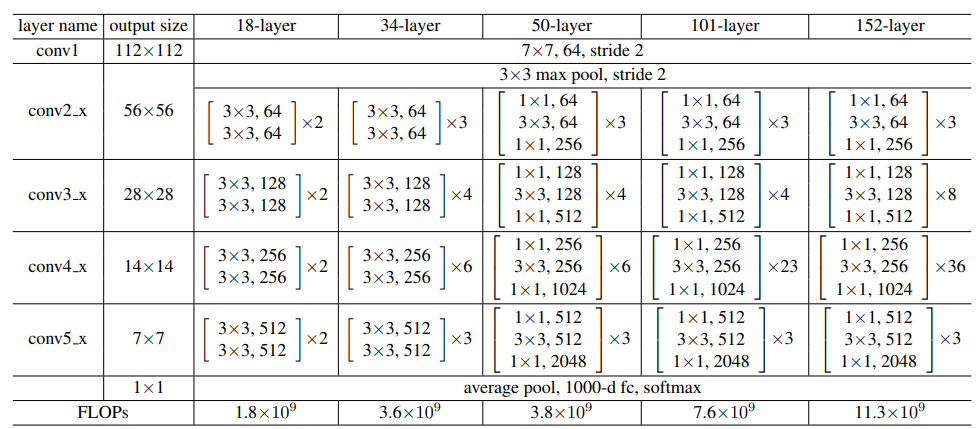

This are the architectures for Resnet different versions

#### First we will be creating a class named block.
Here we will be coding the block for one layer of ResNet which will make it much easier to build the whole architecture

In [ ]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(block, self).__init__()
        self.expansion = 4 ## output channels is 4 times input channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = (1,1), stride = (1,1), padding = (0,0))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = (3,3), stride = (stride, stride), padding = (1,1))
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=(1,1), stride = (1,1), padding = (0,0)) ## Not that the output channels after a block in a resnet layer is 4 times the input channels
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x) ## applying a identity downsample to the input
        x = self.bn1(x) ## batchnorm
        x = self.conv2(x) ## applying a 3x3 convolution
        x = self.bn2(x) ## batchnorm
        x = self.conv3(x) ## applying a identity downsample to the input
        x = self.bn3(x) ## batchnorm
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity ## skip connection
        x = self.relu(x)

        return x
    

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64 ## after applying firt convolutional layer, we get 64 channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride = (2,2), padding = (3, 3)) ## this is the first convolutional layer
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride = (2,2), padding = (1,1))
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.layer1 = self.make_layer(block, layers[0], 64, 1)
        self.layer2 = self.make_layer(block, layers[1], 128, 2)
        self.layer3 = self.make_layer(block, layers[2], 256, 2)
        self.layer4 = self.make_layer(block, layers[3], 512, 2)

        self.fc = nn.Linear(2048, num_classes)

    def make_layer(self, block, num_residual_blocks, out_channels, stride):
        idendity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
            idendity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size = (1,1), stride = (stride, stride)), nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, idendity_downsample, stride))
        self.in_channels = out_channels*4

        ## Here we are making a skip connection after every layer of the resnet. That means one skip connection after first 3 blocks and then after 4 blocks then after 6 blocks and then after 3 blocks in a ResNet50 architecture.

        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [9]:
def ResNet50(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,4,6,3], img_channel, num_classes)

def ResNet101(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,4,23,3], img_channel, num_classes)

def ResNet152(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,8,36,3], img_channel, num_classes)

In [10]:
model = ResNet50()
x = torch.randn(2, 3, 224, 224)
y = model(x).to('cuda')
y.shape

torch.Size([2, 1000])